In [1]:
# Standard Libraries
import os
from itertools import cycle

# Data Science

import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning
from scipy.stats import randint, uniform

from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    confusion_matrix, classification_report, 
    roc_curve, auc, precision_recall_curve,
    average_precision_score, f1_score,
    precision_score, recall_score,
    log_loss, cohen_kappa_score
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

## The task

Try to build a classifier for the MNIST dataset that achieves over 97% accuracy
on the test set. Hint: the KNeighborsClassifier works quite well for this task;
you just need to find good hyperparameter values (try a grid search on the
weights and n_neighbors hyperparameters).

## The Data

The data seems to be very simple. We have been given a *label* column which seems to be the target, and the rest of the 784 features are image pixes. These are 28 x 28 images, just like written in chapter and lab 3. So, we have a computer vision classification problem! Fascinating...

## Detailing the solution

We don't need to pre-process or scale anything here. Picking one random feature column i.e. *pixel100*, we see the min and max of: 0, 255. All sorts of values between these two extremes occur in this feature, which makes sense because an image pixel can fall between exactly those values.

OK. We already have a testing file, so all we need to do is to do cross-validation, RandomizedSearchCV, use KneighborsClassifier with the best hyperparameters, and cross our fingers that the accuracy is over 97%. Speaking of which, for the exercise it may be okay to use accuracy, but what performance measure would actually make sense here? 

It seems that, since KNN is a lazy learner, no binary cross-entropy or gradient descent is used, so simple accuracy or error rate works. But I will definitely use confusion matrices, precision, recall, F-1, ROC/PR curves, and everything learnt in the chapter to make this as robust as possible!

In [2]:
DIRECTORY_PREFIX = '/kaggle/input/digit-recognizer/'
submission, train, test = os.listdir(DIRECTORY_PREFIX)

In [3]:
train_df = pd.read_csv(DIRECTORY_PREFIX + train)
test_df = pd.read_csv(DIRECTORY_PREFIX + test)

train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Steps to implement RandomizedSearchCV

1. Define all the parameters for KNeighborsClassifier, what does what exactly
2. Once I understand this, I will know which types of values make sense for what, and the types of distributions to use
3. Define the parameter grid fully
4. Run RandomizedSearchCV
5. Evaluate the model and see if there are any improvements you can make
6. TESTING TIME

We need to check if the classes are balanced

## Cross Validation Antics

So, running RandomizedSearchCV gave us 96% validation set accuracy and awhopping 100%, badly overfitted training error: KNeighborsClassification is memorizing the entire training set with k=1 neighbors. We're in the process of testing higher ranges of k while excluding k=1 because we know that's optimal one.

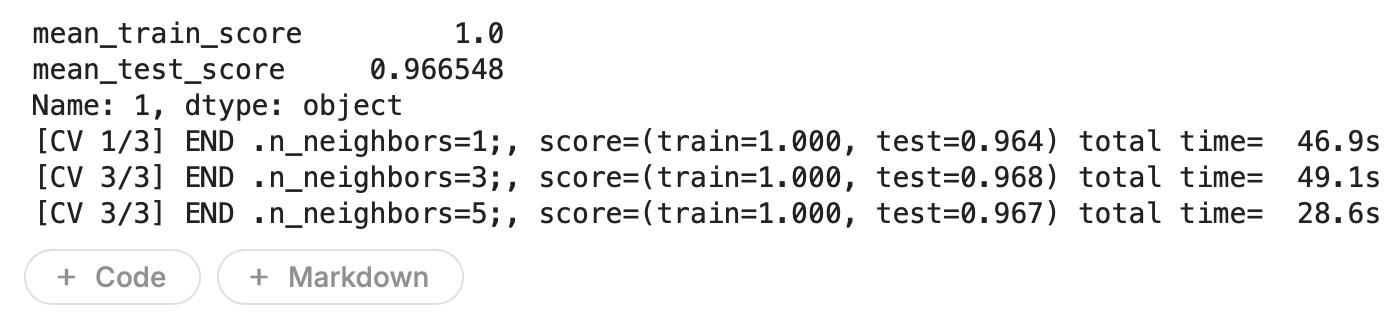

Why? Without actually testing both these models on real-world validation data outside of MNIST,we can't really conclude much about which model is superior. For the current purposes, I will go with one that reaches 95-96 training and above 90 validation. Then,the real work will begin: **collecting digit data out there and testing both models on it...**

In [4]:
train_y = train_df['label']
train_features = train_df.drop('label', axis=1)

In [5]:
print("Class balance: ", train_y.value_counts(), end='\n\n')
print("NaNs???: ", train_df.isna().sum(), end='\n\n')

Class balance:  label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: count, dtype: int64

NaNs???:  label       0
pixel0      0
pixel1      0
pixel2      0
pixel3      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Length: 785, dtype: int64



In [6]:
param_grid = {
    'n_neighbors': [7, 9, 15, 21], 
}

rnd_search = RandomizedSearchCV(
    estimator=KNeighborsClassifier(n_jobs=-1, weights="distance"),
    param_distributions=param_grid,
    n_iter=10,           # Reduced from 30
    cv=3,                # Reduced from 5  
    scoring="accuracy",
    n_jobs=-1,
    verbose=3,            
    random_state=42,
    return_train_score=True
)

rnd_search.fit(train_features, train_y)
print("\nBest hyperparameters:")
print(rnd_search.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



Best hyperparameters:
{'n_neighbors': 7}


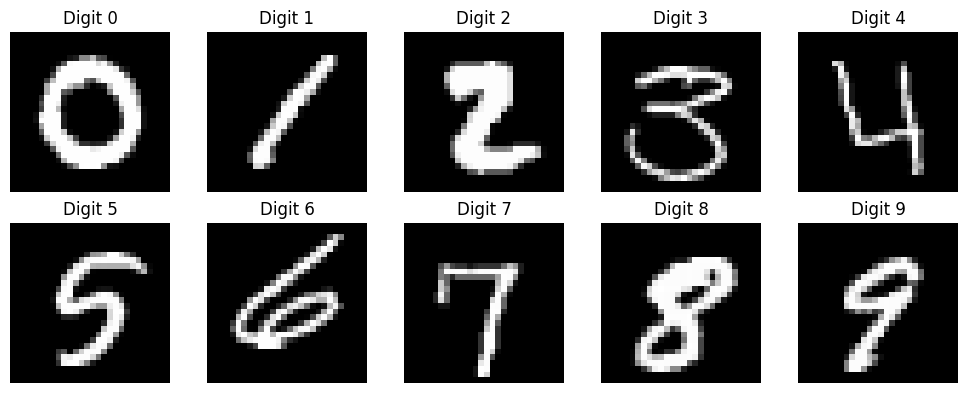

In [7]:
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

for i in range(10):
    sample = train_features[train_y==i].iloc[0].values.reshape(28, 28)
    axes[i//5, i%5].imshow(sample, cmap='gray')
    axes[i//5, i%5].set_title(f'Digit {i}')
    axes[i//5, i%5].axis('off')
    
plt.tight_layout()
plt.show()

In [8]:
best_model = rnd_search.best_estimator_
best_idx = rnd_search.best_index_
results = pd.DataFrame(rnd_search.cv_results_)
best_row = results.iloc[best_idx][['mean_train_score', 'mean_test_score']]
best_row

mean_train_score         1.0
mean_test_score     0.964262
Name: 0, dtype: object

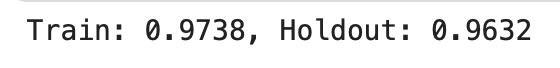



It seems the AI gods have spoken, we have decided upon the k=7 KNN model

In [9]:
from sklearn.model_selection import train_test_split

X_train_small, X_holdout, y_train_small, y_holdout = train_test_split(
    train_df, train_y, test_size=0.2, random_state=42
)

# Train on smaller set, test on holdout
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train_small, y_train_small)

train_score = knn.score(X_train_small, y_train_small)  
holdout_score = knn.score(X_holdout, y_holdout)

print(f"Train: {train_score:.4f}, Holdout: {holdout_score:.4f}")

Train: 0.9738, Holdout: 0.9632


## Exercise 2 - MNIST Augmented

Write a function that can shift an MNIST image in any direction (left, right, up, or down) by one pixel.⁠ Then, for each image in the training set, create four shifted copies (one per direction) and add them to the training set. Finally, train your best model on this expanded training set and measure its accuracy on the test set. You should observe that your model performs even better now! This technique of artificially growing the training set is called data augmentation or training set expansion.

#### What does shifting images actually mean?

To shift an image "(left, right, up, or down) by one pixel", what does that actually mean? We know that MNIST data is 28x28 because it has 784 features. Moving an image horizontally would mean moving across columns and vertically would be up and down rows. Seems easy enough. Mathematically, let's imagine an image,converted into 28x28.

It has 28 rows and 28 columns.

[[5, 8, 2, 0],  ← Row 0
[1, 9, 3, 0],  ← Row 1  
[0, 4, 7, 0],  ← Row 2
[0, 0, 0, 0]]  ← Row 3

[[0, 5, 8, 2],  ← Row 0 shifted
[0, 1, 9, 3],  ← Row 1 shifted
[0, 0, 4, 7],  ← Row 2 shifted  
[0, 0, 0, 0]]  ← Row 3 shifted

[[0, 0, 0, 0],  ← New top row (zeros)
[5, 8, 2, 0],  ← Original Row 0
[1, 9, 3, 0],  ← Original Row 1
[0, 4, 7, 0]]  ← Original Row 2 (Row 3 discarded)


Let's write a function that does that exactly and apply it to the entire dataset .apply/lambda style!

In [10]:
def shift_image(img, direction):
    img = img.values.reshape(28,28)
    shifted_img = None
    shift_amount = 1
    
    if direction == 'up':
        shifted_img = np.roll(img, -shift_amount, axis=0)
        shifted_img[-shift_amount:, :] = 0  # ← This fills bottom rows with zeros

    elif direction == 'down':
        shifted_img = np.roll(img, shift_amount, axis=0)
        shifted_img[:shift_amount, :] = 0   # ← This fills top rows with zeros

    elif direction == 'left':
        shifted_img = np.roll(img, -shift_amount, axis=1)
        shifted_img[:, -shift_amount:] = 0  # ← This fills right columns with zeros

    elif direction == 'right':
        shifted_img = np.roll(img, shift_amount, axis=1)
        shifted_img[:, :shift_amount] = 0   # ← This fills left columns with zeros

    else:
        raise ValueError("Wrong option, weirdo. Please pick between 'up', 'down', 'left', or 'right' for image shifts!")
        
    return shifted_img

## Image shift results

Because shifting by a pixel doesn't do much visually, here's how example shifts to the left and down look when shifted by 10px!

### LEFT
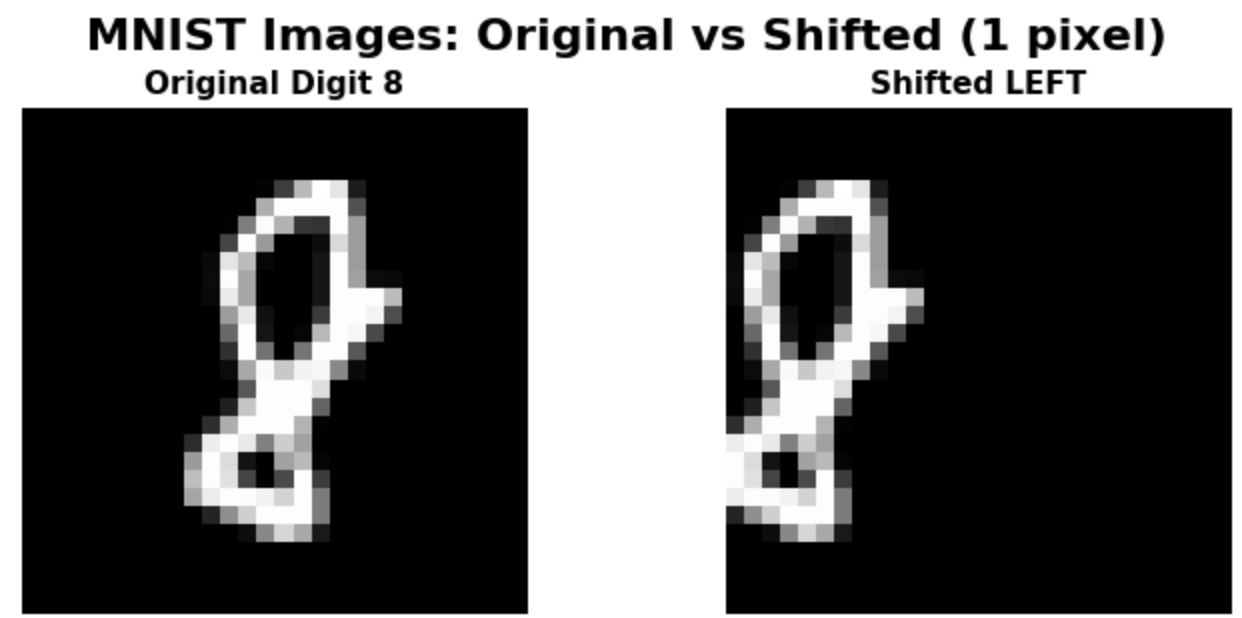

### DOWN

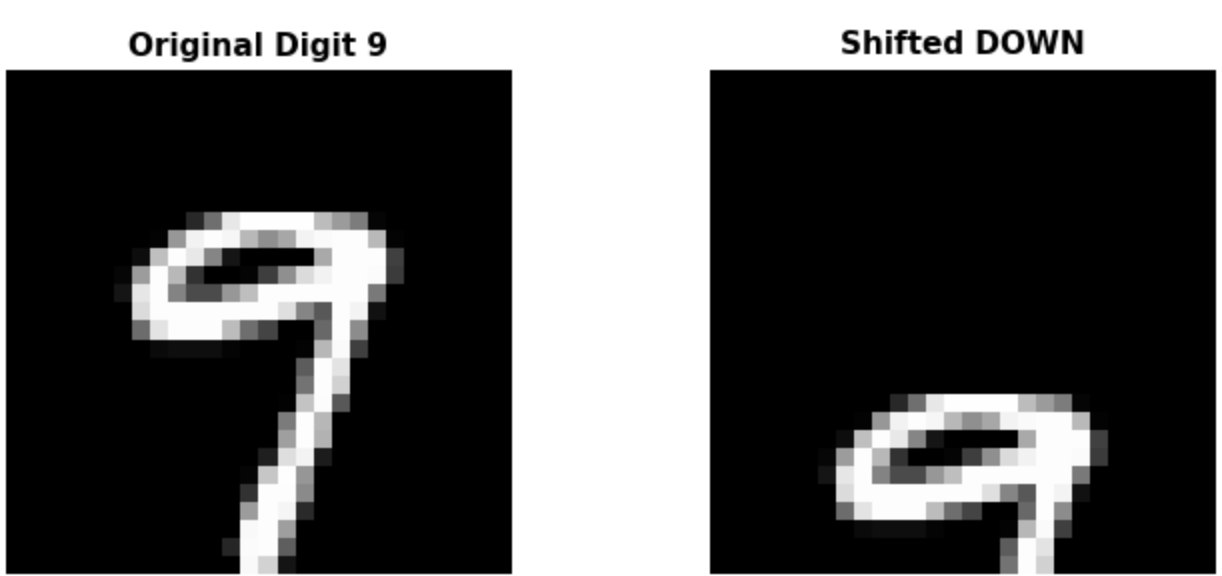


Now, let's build an augmented dataframe of these shifts, and train the best estimator from our previous section to see how our evaluation metric (hopefully) improves.

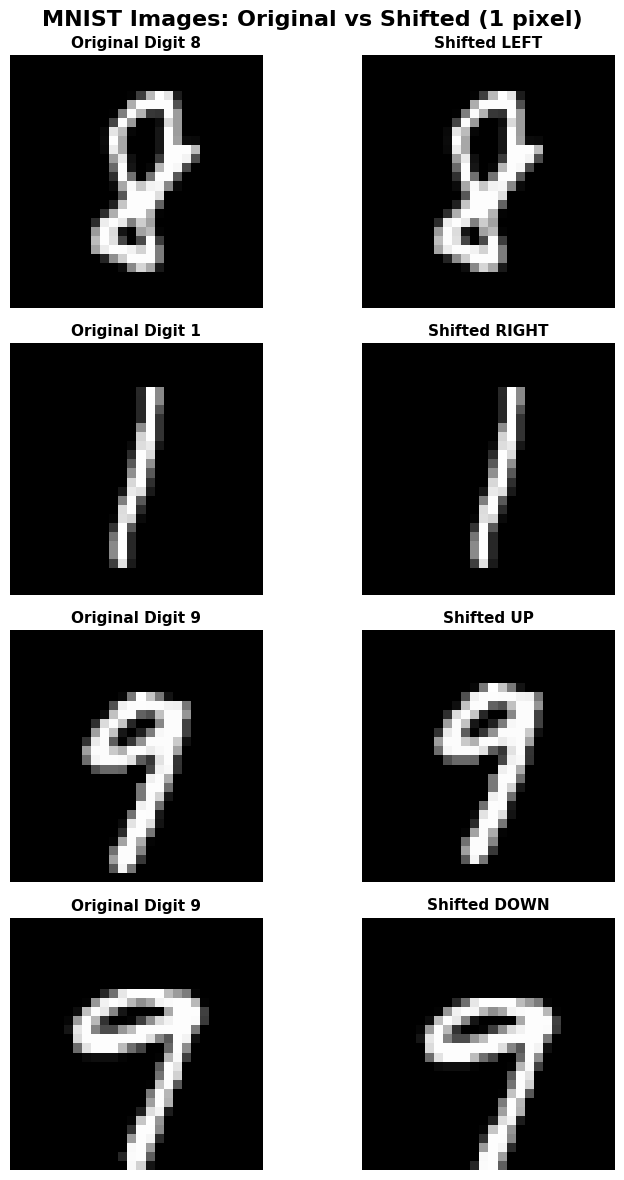

In [11]:
np.random.seed(42)
random_indices = np.random.choice(len(train_features), 4, replace=False)
img = train_features.iloc[11].values.reshape(28,28)
directions = ['left','right','up', 'down']
 
fig, axes = plt.subplots(4, 2, figsize=(8, 12))
fig.suptitle('MNIST Images: Original vs Shifted (1 pixel)', fontsize=16, fontweight='bold')

for i, (idx, direction) in enumerate(zip(random_indices, directions)):
    # Get original image and its label
    original_img = train_features.iloc[idx]
    display_img = original_img.values.reshape(28, 28)
    label = train_y[idx]
    
    # Apply shift
    shifted_img = shift_image(original_img, direction)
    
    # Plot original image (left column)
    axes[i, 0].imshow(display_img, cmap='gray', vmin=0, vmax=255)
    axes[i, 0].set_title(f'Original Digit {label}', fontsize=11, fontweight='bold')
    axes[i, 0].axis('off')
    
    # Plot shifted image (right column)
    im = axes[i, 1].imshow(shifted_img, cmap='gray', vmin=0, vmax=255)
    axes[i, 1].set_title(f'Shifted {direction.upper()}', fontsize=11, fontweight='bold')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()


In [12]:
augmented_images = []

for direction in directions:
    shifted_batch = np.array([shift_image(img, direction) for _, img in train_features.iterrows()])
    augmented_images.append(shifted_batch)

augmented_train_features = np.vstack(augmented_images)
augmented_labels =  np.tile(train_y, len(directions))

In [13]:
augmented_train_features_flat = augmented_train_features.reshape(augmented_train_features.shape[0], -1)

X_train_small, X_holdout, y_train_small, y_holdout = train_test_split(
    augmented_train_features_flat, augmented_labels, test_size=0.2, random_state=42
)

In [14]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train_small, y_train_small)

KNeighborsClassifier(n_neighbors=7)

In [15]:
train_score = knn.score(X_train_small, y_train_small)  
holdout_score = knn.score(X_holdout, y_holdout)

print(f"Train: {train_score:.4f}, Holdout: {holdout_score:.4f}")

[CV 2/3] END .n_neighbors=7;, score=(train=1.000, test=0.963) total time=  58.2s
[CV 1/3] END n_neighbors=15;, score=(train=1.000, test=0.958) total time=  56.6s
[CV 1/3] END n_neighbors=21;, score=(train=1.000, test=0.953) total time=  54.3s
[CV 1/3] END .n_neighbors=9;, score=(train=1.000, test=0.962) total time=  58.1s
[CV 2/3] END .n_neighbors=9;, score=(train=1.000, test=0.963) total time=  56.2s
[CV 3/3] END n_neighbors=15;, score=(train=1.000, test=0.958) total time= 1.0min
[CV 1/3] END .n_neighbors=7;, score=(train=1.000, test=0.964) total time=  59.1s
[CV 3/3] END .n_neighbors=9;, score=(train=1.000, test=0.964) total time=  56.3s
[CV 2/3] END n_neighbors=21;, score=(train=1.000, test=0.952) total time= 1.1min
[CV 3/3] END .n_neighbors=7;, score=(train=1.000, test=0.965) total time= 1.1min
[CV 2/3] END n_neighbors=15;, score=(train=1.000, test=0.957) total time=  58.5s
[CV 3/3] END n_neighbors=21;, score=(train=1.000, test=0.953) total time= 1.0min
Train: 0.9777, Holdout: 0.96

### Results of image shifting


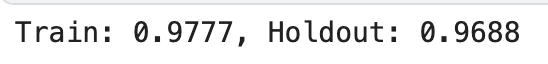

A training increase of 0.0041 and validation set-increase of 0.0056. How about test set?? This augmentation has given me a minor increase in performance, so let's make a couple of predictions and visually check if they match our model's predictions

In [16]:
test_arr = test_df.values
predictions = knn.predict_proba(test_arr)

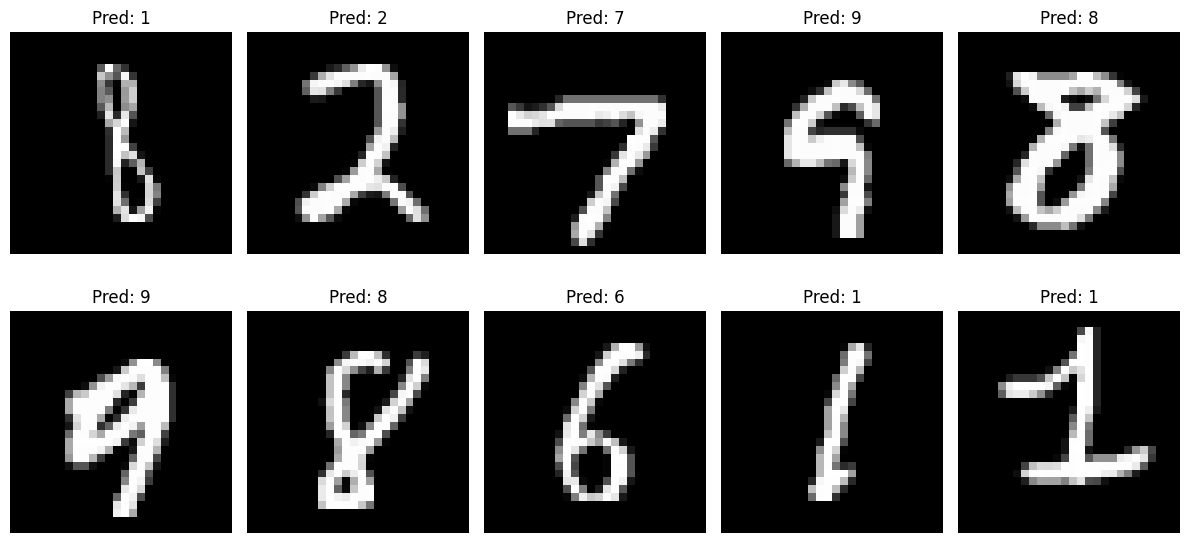

In [17]:
# Show first 10 test images with predictions
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
random_choices = np.random.choice(len(test_arr), size=10, replace=False)

for i in range(len(random_choices)):
    ax = axes[i//5, i%5]
    
    # Reshape back to 28x28 for visualization
    img = test_arr[random_choices[i]].reshape(28, 28)
    ax.imshow(img, cmap='gray')
    
    # Title shows prediction vs actual
    pred = predictions[random_choices[i]]
    color = 'green'
    ax.set_title(f'Pred: {np.argmax(pred)}')
    ax.axis('off')

plt.tight_layout()
plt.show()

### Further analysis

Pretty good, eh? Our model seems to be correctly determining which numbers are which, generally speaking. Of course, it is making mistakes, which means we need to analyze further what kind of mistakes it's making. For instance, in this earlier run, it seems to think an 8 is a 3. 8 and 3 are very similar if you think about it: one is two full circles glued together and the other is two half circles.

Let's go deeper, as promised before

In [18]:
# X_holdout, y_holdout

y_pred = knn.predict_proba(X_holdout)
n_classes = np.unique(y_holdout)
y_pred.shape

(33600, 10)

In [19]:
print(f"y_pred shape: {y_pred.shape}")
print(f"y_pred first row: {y_pred[0]}")
print(f"y_pred sum per row (should be ~1.0): {y_pred[0].sum()}")
print(f"y_holdout shape: {y_holdout.shape}", end='\n\n')

# See how many unique probability patterns you have
unique_rows = len(np.unique(y_pred.round(4), axis=0))
print(f"Unique prediction patterns: {unique_rows} out of {len(y_pred)}")

# Check if most predictions are 100% confident
max_probs = np.max(y_pred, axis=1)
confident_predictions = (max_probs > 0.99).sum()
print(f"Predictions with >99% confidence: {confident_predictions}/{len(y_pred)}", end='\n\n')

y_pred_from_proba = np.argmax(y_pred, axis=1)
accuracy = np.mean(y_pred_from_proba == y_holdout)
macro_f1 = f1_score(y_holdout, y_pred_from_proba, average='macro')
weighted_f1 = f1_score(y_holdout, y_pred_from_proba, average='weighted')
macro_precision = precision_score(y_holdout, y_pred_from_proba, average='macro')
macro_recall = recall_score(y_holdout, y_pred_from_proba, average='macro')

print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Macro F1-Score: {macro_f1:.4f}")
print(f"Weighted F1-Score: {weighted_f1:.4f}")
print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")
    

y_pred shape: (33600, 10)
y_pred first row: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
y_pred sum per row (should be ~1.0): 1.0
y_holdout shape: (33600,)

Unique prediction patterns: 790 out of 33600
Predictions with >99% confidence: 28883/33600

Overall Accuracy: 0.9688
Macro F1-Score: 0.9688
Weighted F1-Score: 0.9688
Macro Precision: 0.9699
Macro Recall: 0.9683


Log Loss (lower=better): 0.2473
Cohen's Kappa: 0.9653



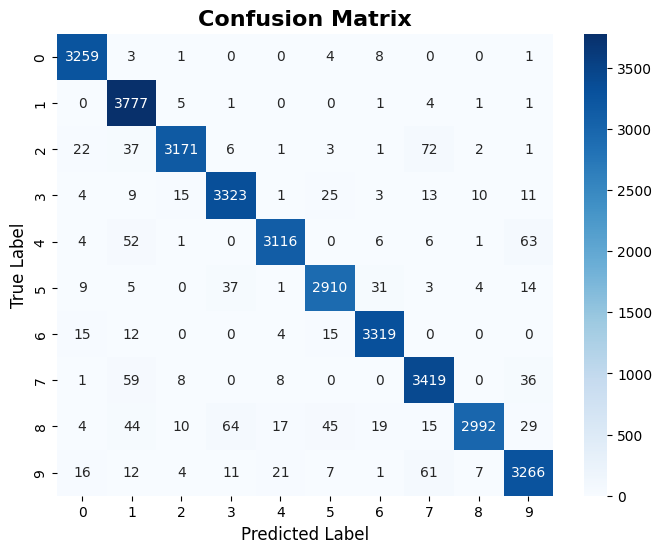

In [20]:
log_loss_score = log_loss(y_holdout, y_pred)
print(f"Log Loss (lower=better): {log_loss_score:.4f}")
kappa = cohen_kappa_score(y_holdout, y_pred_from_proba)
print(f"Cohen's Kappa: {kappa:.4f}", end='\n\n')

cm = confusion_matrix(y_holdout, y_pred_from_proba)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=n_classes, yticklabels=n_classes)
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

In [21]:
# Calculate TPR, FPR, TNR, FNR for each class
per_class_metrics = []

for i, class_name in enumerate(n_classes):
    # True/False Positives/Negatives for class i
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp
    fn = cm[i, :].sum() - tp
    tn = cm.sum() - tp - fp - fn
    
    # Calculate rates
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensitivity/Recall
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # Fall-out
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0  # Specificity
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0  # Miss rate
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1 = 2 * (precision * tpr) / (precision + tpr) if (precision + tpr) > 0 else 0
    
    per_class_metrics.append({
        'TPR (Recall)': tpr,
        'FPR': fpr,
        'TNR (Specificity)': tnr,
        'FNR': fnr,
        'Precision': precision,
        'F1-Score': f1,
        'Support': tp + fn
    })

# Display as DataFrame
metrics_df = pd.DataFrame(per_class_metrics)
print(metrics_df.round(4))

   TPR (Recall)     FPR  TNR (Specificity)     FNR  Precision  F1-Score  \
0        0.9948  0.0025             0.9975  0.0052     0.9775    0.9861   
1        0.9966  0.0078             0.9922  0.0034     0.9419    0.9685   
2        0.9563  0.0015             0.9985  0.0437     0.9863    0.9711   
3        0.9733  0.0039             0.9961  0.0267     0.9654    0.9694   
4        0.9591  0.0017             0.9983  0.0409     0.9833    0.9710   
5        0.9655  0.0032             0.9968  0.0345     0.9671    0.9663   
6        0.9863  0.0023             0.9977  0.0137     0.9793    0.9828   
7        0.9683  0.0058             0.9942  0.0317     0.9516    0.9599   
8        0.9237  0.0008             0.9992  0.0763     0.9917    0.9565   
9        0.9589  0.0052             0.9948  0.0411     0.9544    0.9566   

   Support  
0     3276  
1     3790  
2     3316  
3     3414  
4     3249  
5     3014  
6     3365  
7     3531  
8     3239  
9     3406  


### Log Loss

Log_loss i.e. cross-entropy needs the full probability distribution!

### Confusion Matrix

Different classes make different errors. The class 1 has more true positives, but also it has lesser true negatives meaning it makes either more FP's or FN's (we know in this case that it's the former). Analyzing this has some value in terms of making our classifier better. We will do so a several cells below, where we'll calculate the error rate of every misclassification i.e. FN / row total.

Reading confusion matrices can be confusing, especially in the case of multiclass. Here's the golden rule: **TP, FP, yada yada all depends on the perspectives. TP/FP/TN/FN are ALWAYS relative to ONE specific class at a time.**. 

Example, cm[2, 7]. From the perspective of the actual label and the model prediction's, a value can be called FP or FN. cm[2, 7] = 72; from the perspective of class 2, the true label, a prediction of 7 would be a false negative. BUT, from the viewpoint of class 7, the predicted class, a label of 2 would be a false positive because the predicted class is positive i.e. 7, but is isn't really so (true class is 2). 

How about the tricky one, true negatives? From Class 2's perspective, True Negatives are: all samples that are NOT true 2s AND were NOT predicted as 2s. So, all values outside the row and column for the predicted or actual 2 values.

#### Cheatsheet: 

TP: cm[X,X] (diagonal) <br>
FN: Rest of row X (true Xs predicted as something else) <br>
FP: Rest of column X (non-Xs predicted as X) <br>
TN: Everything else (non-Xs correctly predicted as non-X) <br>

### ROC Curve

A very good evaluation metric, where the y-axis is the TPR and x-axis is FPR. We want TPR to be 100% and FPR to be 0%, meaning the ideal ROC curve point is at the top left, maximizing the AUROC. 

This, while typically used for binary classifiers, can be extended to something like MNIST too; however, the labels must be binarized, due to the ambiguity of thresholding for multiclass.

In the binary case, ROC curves are created by testing every single threshold value to see how the curve reacts with changing thresholds.

Probabilities (binary case): [0.3, 0.7, 0.9, 0.1, 0.8] <br>
Threshold = 0.5 <br>
Predictions: [0, 1, 1, 0, 1]  # Clear binary decision <br>

And so we go from threshold to threshold seeing how our metrics (TPR and FPR) changes in the binary case. But what about the multiclass case?

Probabilities for 3 classes: 
Sample 1: [0.6, 0.3, 0.1]  # Predicted: Class 0 <br>
Sample 2: [0.4, 0.4, 0.2]  # Predicted: Class 0 (barely) <br>

Question: What threshold do we vary for ROC curve? <br>
Option A: Threshold on Class 0 probability? <br>
Option B: Threshold on "confidence" (max probability)? <br>
Option C: Something else? <br>

#### Binarizing for multiclass

Original: Classes 0,1,2,3,4,5,6,7,8,9 <br>
Binarized for Class 7: "Class 7" vs "Not Class 7" <br>

For each class, we ask: <br>
"Is this Class X?" (positive) vs "Is this any other class?" (negative)

### Precision, Recall, F-1, and KNeighborsClassifier


With MNIST, we have clearly seperated digits with little ambiguity. And the dataset is really balanced, as we have seen above. When we look at our model's predictions, most of them are "hard" predictions i.e. the model is 100% confident in what it is predicting. In fact, 85% of predictions are that way. Only in the rest 15%, the neighbors disagree about what the digit could be resulting in a unique probability distribution! 

Meaning = **we end up in a case where precision, recall, and F-1 are equal**

#### What??? This can happen?? 

I thought precision and recall were tradeoffs!! Well, typically, yes. When we learn machine learning through courses and books and things, this is what we miss: theory is malleable to change **DEPENDING ON THE PROBLEM**. We talk in generalities as we learn, but sometimes unique situations occur. This one is no different. 

Here's the rundown. When your model is highly confident, precision becomes equal to recall. The tradeoff occurs due to thresholding. If you set a low threshold, we classify more instances as positive; if you set a high threshold, most instances are negative. But if the model is 100% sure (like it is in this case), the prediction is almost binary. \\

**When error patterns are similar across classes → Precision ≈ Recall ≈ F1**


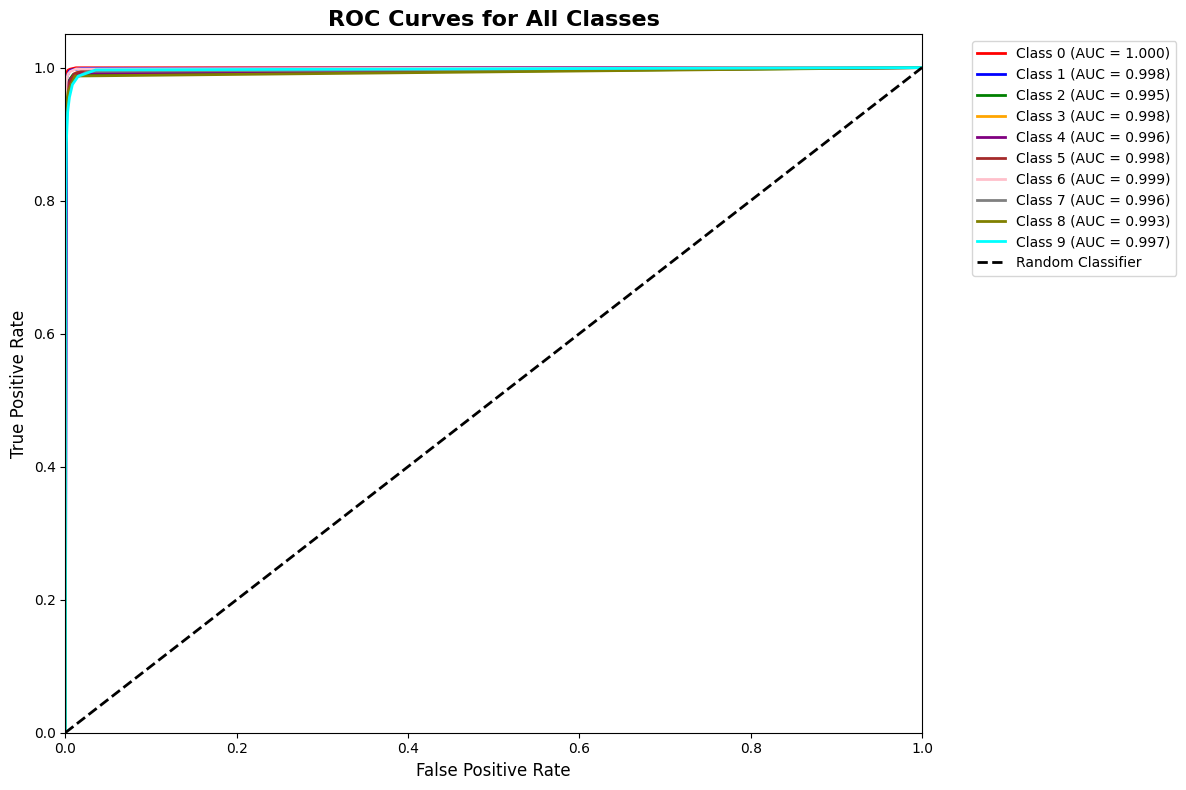

In [22]:
y_true_bin = label_binarize(y_holdout, classes=n_classes)

# Calculate ROC curve for each class
fpr_dict = {}
tpr_dict = {}
roc_auc = {}

plt.figure(figsize=(12, 8))
colors = cycle(['red', 'blue', 'green', 'orange', 'purple', 
               'brown', 'pink', 'gray', 'olive', 'cyan'])

for i, color in zip(n_classes, colors):
    fpr_dict[i], tpr_dict[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr_dict[i], tpr_dict[i])
    
    plt.plot(fpr_dict[i], tpr_dict[i], color=color, lw=2,
            label=f'Class {n_classes[i]} (AUC = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves for All Classes', fontsize=16, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Macro-averaged ROC AUC: 0.9970
PRECISION-RECALL CURVE ANALYSIS


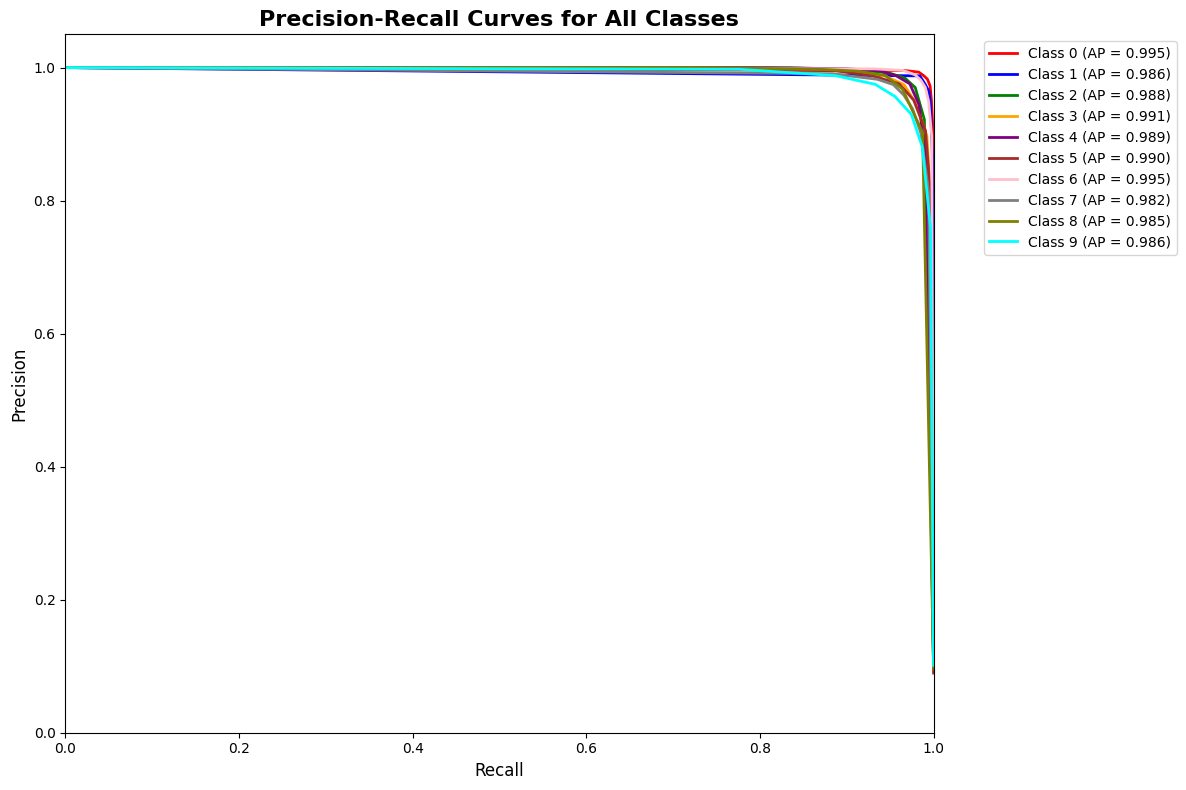

Macro-averaged Average Precision: 0.9888
MISCLASSIFICATION ANALYSIS
Top 10 Misclassification Patterns:
    True Class  Predicted Class  Count  Error Rate
17           2                7     72      0.0217
56           8                3     64      0.0198
35           4                9     63      0.0194
69           9                7     61      0.0179
49           7                1     59      0.0167
30           4                1     52      0.0160
58           8                5     45      0.0139
54           8                1     44      0.0136
38           5                3     37      0.0123
12           2                1     37      0.0112


In [23]:
# Macro and Micro ROC AUC
macro_roc_auc = np.mean(list(roc_auc.values()))
print(f"Macro-averaged ROC AUC: {macro_roc_auc:.4f}")

print("PRECISION-RECALL CURVE ANALYSIS")
print("=" * 50)

plt.figure(figsize=(12, 8))

avg_precision_scores = {}
for i, color in zip(n_classes, colors):
    precision_curve, recall_curve, _ = precision_recall_curve(y_true_bin[:, i], y_pred[:, i])
    avg_precision_scores[i] = average_precision_score(y_true_bin[:, i], y_pred[:, i])
    
    plt.plot(recall_curve, precision_curve, color=color, lw=2,
            label=f'Class {n_classes[i]} (AP = {avg_precision_scores[i]:.3f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curves for All Classes', fontsize=16, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

macro_avg_precision = np.mean(list(avg_precision_scores.values()))
print(f"Macro-averaged Average Precision: {macro_avg_precision:.4f}")

print("MISCLASSIFICATION ANALYSIS")
print("=" * 50)

# Find most confused pairs
confusion_pairs = []
for i in n_classes:
    for j in n_classes:
        if i != j and cm[i, j] > 0:
            confusion_pairs.append({
                'True Class': n_classes[i],
                'Predicted Class': n_classes[j], 
                'Count': cm[i, j],
                'Error Rate': cm[i, j] / cm[i, :].sum()
            })

# Sort by count and show top confusions
confusion_df = pd.DataFrame(confusion_pairs).sort_values('Count', ascending=False)
print("Top 10 Misclassification Patterns:")
print(confusion_df.head(10).round(4))

Average confidence (correct predictions): 0.9722
Average confidence (incorrect predictions): 0.6653


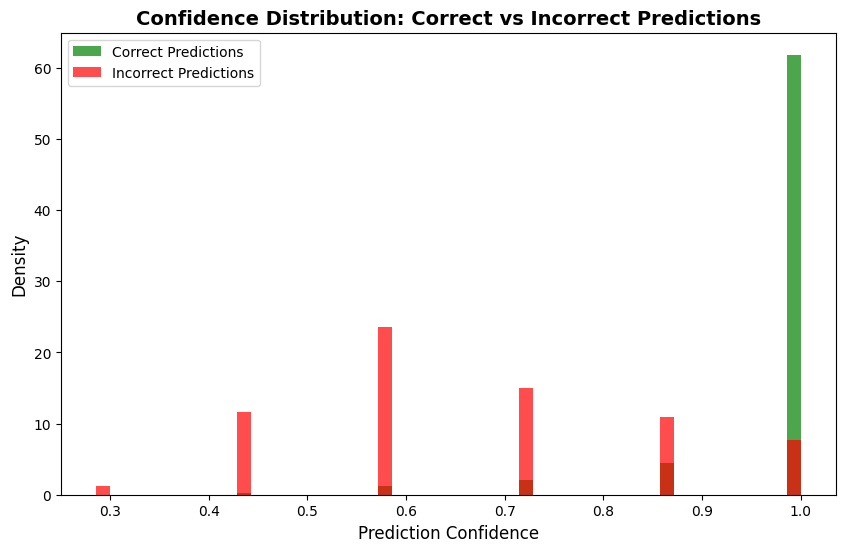

In [24]:
correct_predictions = y_pred_from_proba == y_holdout

# For each row, take the maximum probability value belonging to any class
# How confident the model is in its prediction for each sample
confidence_scores = np.max(y_pred, axis=1)

print(f"Average confidence (correct predictions): {confidence_scores[correct_predictions].mean():.4f}")
print(f"Average confidence (incorrect predictions): {confidence_scores[~correct_predictions].mean():.4f}")

plt.figure(figsize=(10, 6))
plt.hist(confidence_scores[correct_predictions], bins=50, alpha=0.7, 
         label='Correct Predictions', color='green', density=True)
plt.hist(confidence_scores[~correct_predictions], bins=50, alpha=0.7, 
         label='Incorrect Predictions', color='red', density=True)
plt.xlabel('Prediction Confidence', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Confidence Distribution: Correct vs Incorrect Predictions', fontsize=14, fontweight='bold')
plt.legend()
plt.show()

### Production readiness checks!


What does this even entail? You could have some metrics that need to be met. They could be decided upon by the engineering team, could come from the stakeholders, the people who will use and/or be affected by the application, whatever have you. For instance, the application could require a TPR of greater than some value, decided upon the business and problem context... We will consider two scenarios that will demonstrate this point at the end!

Also, what is the average confidence of correct predictions versus incorrect ones? This matters because we want to build models that are confidently right, and uncertainly wrong. A lesson on how to act in real life too: when you are facing a situation you're uncertain about, hesitate. Don't be overconfident and wrong, just like your ML models (BCE penalizes this heavily, which is why it is such an awesome metric)! From the histograms, we see a small fraction of predictions which are just this, which is bad... I would focus on fixing these ones first.

Let's check the worst class error manually for now! We can build a suite of metric thresholds, loop through them, and return False if any of them fail. Run this test every time we're preparing to deploy.

In [25]:
worst_class_err = 1 - metrics_df['TPR (Recall)'].min()

if worst_class_err > 0.1:
    print("We cannot deploy this model just yet!!") 

### Two different context, two different set of metrics (plus a bonus)


1. Cancer screening - in this situation, false negatives are much more disastrous than false positives. Optimizing for high recall is more important
2. Spam filter - here, the opposite is the case. False positives are worse than false negatives, as an important email getting tagged as spam is worse than a spam email not getting tagged and reaching your inbox, which is just a minor annoyance compared to the earlier scenario. Precision is important.
3. Bonus, financial instituition - in these cases, we want to maximize both, which is tough because we know that these are tradeoffs one must make in ML. Likely, instituitions dynamically change their strategy on the basis of how big the transactions are! A \\$50000 check needs different treatment (higher recall) from a \\$50 check (precision)

### Exercise 3 - Titanic



In [26]:
DIRECTORY_PREFIX = '/kaggle/input/titanic'
gender_submission, test, train = os.listdir(DIRECTORY_PREFIX)

### Preliminary Data Analysis


Let's break down the features we have, NaN values, scales, and types of these features! 

PassengerID: can be removed, unless you find a creative way to engineer features with this <br>
Survived: the target feature. 0 or 1 <br>
PClass: the socio-economic class of the passengers. This will be highly important. Remember from the movie that the bottom section, where all the poor people were, were drowing way before all the rich people up top, who were still partying. 1, 2, or 3, **categorical** <br>
Age:  has 177 missing values <br>
Name: string. Recall that one notebook which did very creative things with this feature. We can group people with same last names, alongside other signals, to determine if people were part of a family etc. TLDR -> before you remove features, think really carefully <br>
Sex: mostly males aboard, string feature, male or female 
